# Filtros Adaptivos RLS

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

%matplotlib inline

Text(0.5, 1.0, 'Señal detectada $x[n]$')

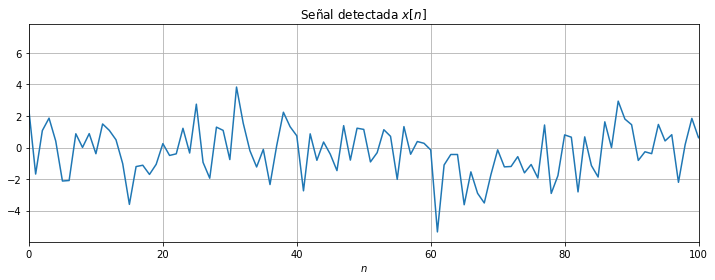

In [2]:
# Wiener filter - Denoising
N = 2000

# Señal deseada - Proceso Autoregresivo
alpha = 0.95
b = [np.sqrt(1-alpha**2)]
d = signal.lfilter(b,[1,-alpha],np.random.randn(N))

# Ruido blanco
sigv = np.sqrt(2)
v = sigv*np.random.randn(N)

x = d + v

plt.figure(figsize=[12,4])
plt.plot(x)
plt.grid('on')
plt.xlabel('$n$')
plt.xlim([0,100])
plt.title('Señal detectada $x[n]$')


Error medio cuadrático:  0.3032188938804641
Error medio cuadrático (ideal):  0.33265704134738094


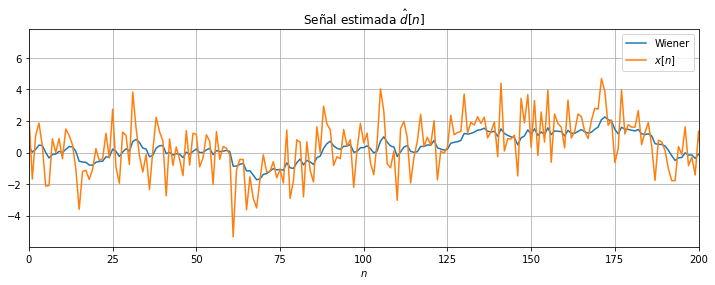

In [3]:
# Wiener Filter

M = 11

# Matriz Rx = Rd + Rv
Rd = np.zeros((M,M))
for i in range(M):
    for j in range(M):
        Rd[i,j] = alpha**np.abs(i-j)
Rv = sigv**2 * np.eye(M)
Rx = Rd + Rv

# Vector rdx = rd
rdx = alpha**np.arange(M)

# Calculando Filtro Wiener
W = np.dot(np.linalg.inv(Rx),rdx)
dW = signal.lfilter(W,[1],x)

plt.figure(figsize=[12,4])
plt.plot(dW)
plt.plot(x)

plt.grid('on')
plt.xlabel('$n$')
plt.xlim([0,200])
plt.title('Señal estimada $\hat{d}[n]$')
plt.legend(['Wiener','$x[n]$'])

# Calculando algunos parámetros
print('Error medio cuadrático: ',np.mean((d-dW)**2))
print('Error medio cuadrático (ideal): ',rdx[0] - np.dot(W,rdx))

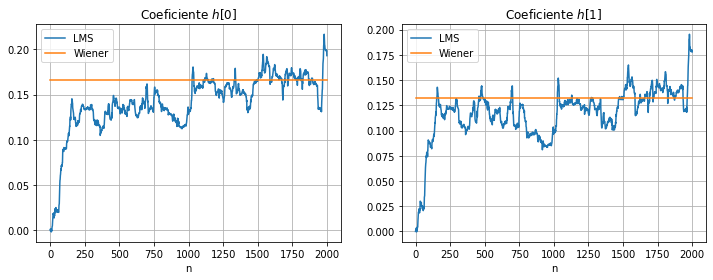

In [4]:
# Implementando filtro adaptivo LMS

h_LMS = np.zeros((M,N))
d_LMS = np.zeros(N)
mu = 0.001
xx = np.zeros(M)
for n in range(N-1):
    xx = np.roll(xx,1)
    xx[0] = x[n]
    d_LMS[n] = np.dot(h_LMS[:,n],xx)
    en = d[n] - d_LMS[n]
    h_LMS[:,n+1] = h_LMS[:,n] + 2 * mu * en * xx
    
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_LMS[0,:])
plt.plot([0,N],[W[0],W[0]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['LMS','Wiener'])

plt.subplot(1,2,2)
plt.plot(h_LMS[1,:])
plt.plot([0,N],[W[1],W[1]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['LMS','Wiener'])


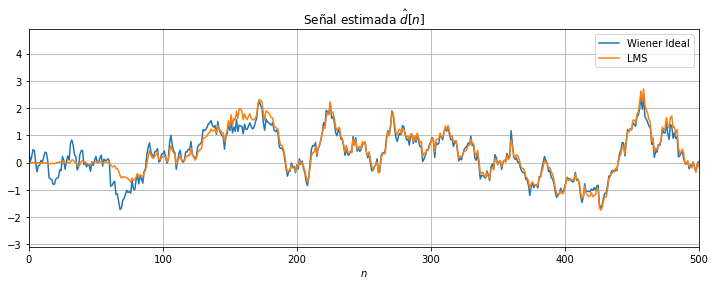

In [5]:
# Comparando Wiener ideal vs. LMS

plt.figure(figsize=[12,4])
plt.plot(dW)
plt.plot(d_LMS)

plt.grid('on')
plt.xlabel('$n$')
plt.xlim([0,500])
#plt.xlim([500,1000])
plt.title('Señal estimada $\hat{d}[n]$')
plt.legend(['Wiener Ideal','LMS'])


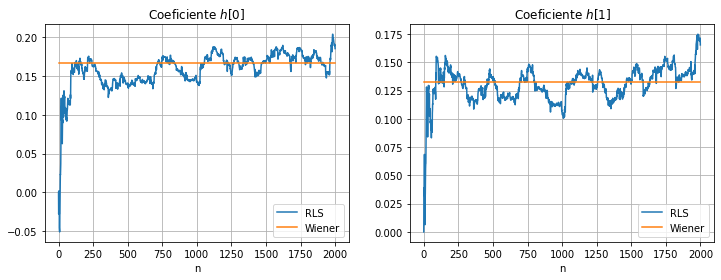

In [6]:
# Implementando filtro adaptivo RLS

h_RLS = np.zeros((M,N))
d_RLS = np.zeros(N)
lamb = 0.995
Pn = np.eye(M)/M
for n in range(1,N):
    if n>=M:
        xx = x[n:n-M:-1]
    else:
        xx = np.concatenate((x[n::-1],np.zeros(M-n-1)))
    xx = xx.reshape((M,1))
    alphan = d[n] - np.matmul(h_RLS[:,n-1].T,xx)
    Zn = np.matmul(Pn,xx)
    Gn = Zn/(lamb + np.matmul(xx.T,Zn))
    Pn = (1/lamb) * (Pn-np.matmul(Gn,Zn.T))
    h_RLS[:,n] = h_RLS[:,n-1] + alphan*Gn[:,0]
    d_RLS[n] = np.matmul(h_RLS[:,n].T,xx)
    
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_RLS[0,:])
plt.plot([0,N],[W[0],W[0]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['RLS','Wiener'])

plt.subplot(1,2,2)
plt.plot(h_RLS[1,:])
plt.plot([0,N],[W[1],W[1]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['RLS','Wiener'])


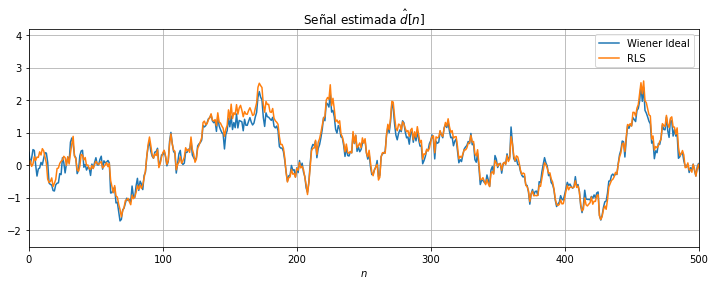

In [7]:
# Comparando Wiener ideal vs. RLS

plt.figure(figsize=[12,4])
plt.plot(dW)
plt.plot(d_RLS)

plt.grid('on')
plt.xlabel('$n$')
plt.xlim([0,500])
plt.title('Señal estimada $\hat{d}[n]$')
plt.legend(['Wiener Ideal','RLS'])


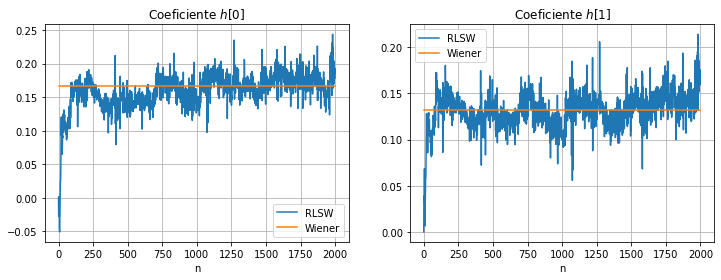

In [22]:
# Implementando RLS con ventana desplazable

h_RLSW = np.zeros((M,N))
d_RLSW = np.zeros(N)
Pn = np.eye(M)/M
L = 50
for n in range(1,N):
    if n>=M:
        xx = x[n:n-M:-1]
    else:
        xx = np.concatenate((x[n::-1],np.zeros(M-n-1)))
    xx = xx.reshape((M,1))

    if n-L>=M:
        xxL = x[n-L:n-L-M:-1]
    elif n-L>=0:
        xxL = np.concatenate((x[n-L::-1],np.zeros(M-n+L-1)))
    else:
        xxL = np.zeros(M)
    xxL = xxL.reshape((M,1))
    
    Zn = np.matmul(Pn,xx)
    Gn = Zn/(1 + np.matmul(xx.T,Zn))
    alphan = d[n] - np.matmul(h_RLS[:,n-1].T,xx)
    hn = h_RLS[:,n-1] + alphan*Gn[:,0]
    
    PnL = Pn - np.matmul(Gn,Zn.T)
    ZnL = np.matmul(PnL,xxL)
    GnL = ZnL/(1-np.matmul(xxL.T,ZnL))
    if n-L>=0:
        alphanL = d[n-L] - np.matmul(hn.T,xxL)
    else:
        alphanL = 0 - np.matmul(hn.T,xxL)

    h_RLSW[:,n] = hn - alphanL*GnL[:,0]
    Pn = PnL + np.matmul(GnL,ZnL.T)
    
    d_RLSW[n] = np.matmul(h_RLSW[:,n].T,xx)
    
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_RLSW[0,:])
plt.plot([0,N],[W[0],W[0]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['RLSW','Wiener'])

plt.subplot(1,2,2)
plt.plot(h_RLSW[1,:])
plt.plot([0,N],[W[1],W[1]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['RLSW','Wiener'])


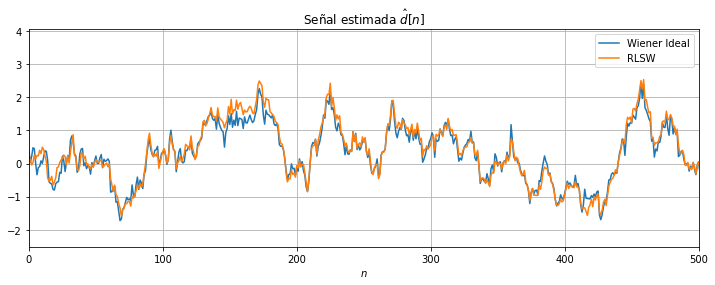

In [23]:
# Comparando Wiener ideal vs. RLS Windowed

plt.figure(figsize=[12,4])
plt.plot(dW)
plt.plot(d_RLSW)

plt.grid('on')
plt.xlabel('$n$')
plt.xlim([0,500])
#plt.xlim([500,1000])
plt.title('Señal estimada $\hat{d}[n]$')
plt.legend(['Wiener Ideal','RLS Windowed'])


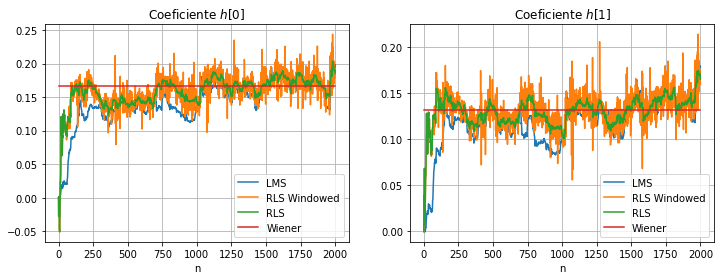

In [24]:
# Comparando todos los algoritmos

plt.figure(figsize=[12,4])

plt.subplot(1,2,1)
plt.plot(h_LMS[0,:])
plt.plot(h_RLSW[0,:])
plt.plot(h_RLS[0,:])
plt.plot([0,N],[W[0],W[0]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['LMS','RLS Windowed','RLS','Wiener'])

plt.subplot(1,2,2)
plt.plot(h_LMS[1,:])
plt.plot(h_RLSW[1,:])
plt.plot(h_RLS[1,:])
plt.plot([0,N],[W[1],W[1]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['LMS','RLS Windowed','RLS','Wiener'])
